<a href="https://colab.research.google.com/github/tsjannoun123-netizen/AI-for-Med.Diagnos.-Prediction-AAI_643O_O11_202610/blob/main/Week5_lesson1_Saera_Rawas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for practical exercises | Week #5 Lesson #1

## Introduction

This notebook contains practical hands-on exercises for the lesson about *Assessing Fairness and Bias*.


Using the [NIH ChestX-ray-14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset with demographic labels, you will know how to analyze the results of a classification model regarding fairness on a real-world clinical problem:
* Comparing performance of a model across groups of population; compute accuracy, TPR, FPR, and PPV for at least two protected groups.
* Select and justify an appropriate fairness criterion.
* Apply a post processing mitigation strategy.
* Re-evaluate metrics and discuss trade-offs.

## Dataset

[NIH ChestX-ray-14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined fourteen disease image labels (where each image can have multi-labels), mined from the associated radiological reports using natural language processing.
Fourteen common thoracic pathologies include Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening, Cardiomegaly, Nodule, Mass and Hernia.

It contains:
1. 112,120 frontal-view chest X-ray PNG images in 1024*1024 resolution (under images folder)
2. Meta data for all images (Data_Entry_2017.csv): Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, Original Image Size and Original Image Pixel Spacing.
3. Bounding boxes for ~1000 images (BBox_List_2017.csv): Image Index, Finding Label, Bbox[x, y, w, h]. [x y] are coordinates of each box's topleft corner. [w h] represent the width and height of each box.
4. Two data split files (train_val_list.txt and test_list.txt) are provided. Images in the ChestX-ray dataset are divided into these two sets on the patient level. All studies from the same patient will only appear in either training/validation or testing set.

Here, we will use a subsample of this dataset along with pretrained models from the last week.

In [1]:
#@title import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from glob import glob
import warnings

warnings.filterwarnings(action="ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
!pip install pydicom SimpleITK -q

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from torchvision import tv_tensors

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

from PIL import Image
import pydicom

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import warnings
warnings.filterwarnings(action="ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

import argparse
import math
import os
from glob import glob

!pip install -U segmentation-models-pytorch -q
import albumentations as A
import numpy as np
import pandas as pd
import SimpleITK as sitk
sitk.ProcessObject.SetGlobalWarningDisplay(False)
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00


In [2]:
import torch, torchvision; print(torch.__version__, torchvision.__version__)


2.8.0+cu126 0.23.0+cu126


### Download and load the data

If needed, run the following cells to download and unzip the dataset.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the data folder. By default, it will be stored at the root of this repository.</b> <br>
<b>If you have already downloaded the dataset, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [3]:
DATA_PATH = './'

!curl https://uni-bonn.sciebo.de/s/J3GFK3bsHGDfwAC/download/data_cxr8.zip --output {DATA_PATH}/data.zip
!unzip {DATA_PATH}/data.zip -d {DATA_PATH}

Streaming output truncated to the last 5000 lines.
  inflating: ./images/00020408_013.png  
  inflating: ./images/00020408_015.png  
  inflating: ./images/00020408_018.png  
  inflating: ./images/00020408_023.png  
  inflating: ./images/00020408_026.png  
  inflating: ./images/00020408_034.png  
  inflating: ./images/00020408_039.png  
  inflating: ./images/00020408_041.png  
  inflating: ./images/00020408_042.png  
  inflating: ./images/00020408_043.png  
  inflating: ./images/00020408_045.png  
  inflating: ./images/00020408_048.png  
  inflating: ./images/00020408_051.png  
  inflating: ./images/00020408_056.png  
  inflating: ./images/00020408_060.png  
  inflating: ./images/00020408_061.png  
  inflating: ./images/00020410_001.png  
  inflating: ./images/00020410_002.png  
  inflating: ./images/00020410_005.png  
  inflating: ./images/00020410_006.png  
  inflating: ./images/00020410_007.png  
  inflating: ./images/00020415_002.png  
  inflating: ./images/00020419_000.png  
  infl

In [4]:
!rm -rf {DATA_PATH}/test_df.csv

In [5]:
!curl https://uni-bonn.sciebo.de/s/Xjw6si6CsyZ7iGx/download/test_df.csv --output {DATA_PATH}/test_df.csv
!curl https://uni-bonn.sciebo.de/s/ogDQemxp6nLxfTq/download/train_df.csv --output {DATA_PATH}/train_df.csv
!curl https://uni-bonn.sciebo.de/s/imoCW6qEj9bP8Ke/download/val_df.csv --output {DATA_PATH}/val_df.csv

!curl https://uni-bonn.sciebo.de/s/ZJqSBJDcdfa6LY7/download/densenet121-classification.pth --output ./densenet121-classification.pth
!curl https://uni-bonn.sciebo.de/s/2fwbiwH9CjHBPPm/download/efficientnet-classification.pth --output ./efficientnet-classification.pth
!curl https://uni-bonn.sciebo.de/s/mkJ5qwLAcHZ5QTk/download/swintransformer-classification.pth --output ./swintransformer-classification.pth


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54159  100 54159    0     0  42021      0  0:00:01  0:00:01 --:--:-- 42048
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189k  100  189k    0     0   131k      0  0:00:01  0:00:01 --:--:--  131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21765  100 21765    0     0  20009      0  0:00:01  0:00:01 --:--:-- 20022
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.1M  100 27.1M    0     0  5702k      0  0:00:04  0:00:04 --:--:-- 8472k
  % Total    % Received % Xferd  Average Speed   Tim

## Load dataframe
We start off by loading the previous week dataset splits. Our goal is to analyse the behavior of a model across population groups.

In [6]:
# Load and observe available data
train_df = pd.read_csv('./train_df.csv')
val_df = pd.read_csv('./val_df.csv')
eval_df = pd.read_csv('./test_df.csv')

dataset = pd.concat([train_df, val_df, eval_df])

print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Evaluation DataFrame shape:", eval_df.shape)
dataset

Train DataFrame shape: (2817, 12)
Validation DataFrame shape: (313, 12)
Evaluation DataFrame shape: (783, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Binary Label
0,00021654_000.png,Effusion,0,21654,68,F,PA,2506,2991,0.143000,0.143000,1
1,00019952_000.png,No Finding,7,19952,39,M,PA,3056,2544,0.139000,0.139000,0
2,00023379_000.png,No Finding,0,23379,30,M,PA,2500,2048,0.168000,0.168000,0
3,00006875_030.png,No Finding,21,6875,58,F,PA,2562,2991,0.143000,0.143000,0
4,00004085_003.png,No Finding,10,4085,55,F,PA,2021,2020,0.194311,0.194311,0
...,...,...,...,...,...,...,...,...,...,...,...,...
778,00019011_000.png,No Finding,0,19011,19,F,PA,2376,2202,0.143000,0.143000,0
779,00021795_000.png,Effusion,0,21795,64,F,PA,2992,2991,0.143000,0.143000,1
780,00006772_000.png,No Finding,0,6772,39,M,PA,2048,2500,0.171000,0.171000,0
781,00023747_000.png,No Finding,0,23747,33,M,PA,2582,2613,0.143000,0.143000,0


In this dataset, we have access to a few elements that allow us to group patient across categories, for instance:
* `Sex/Gender`
* `Age`

We will first visualize the number of patients within each group.

<b>Q1.</b> What potential sources of bias do you see across categories, and which one is the less bias?

In [7]:
bins = [0, 50, 100]
labels = ['<50', '50+']
eval_df['Age Group'] = pd.cut(eval_df['Patient Age'], bins=bins, labels=labels, right=True, include_lowest=True)
eval_df.groupby(['Age Group']).count()['Patient ID']

,Patient ID
Age Group,
<50,381
50+,402


In [8]:
grouped_df = eval_df.groupby(['Patient Age', 'Patient Sex', 'Binary Label']).size().reset_index(name='count')
display(grouped_df)

,Patient Age,Patient Sex,Binary Label,count
0,3,M,0,1
1,4,M,0,1
2,6,F,0,1
3,7,F,0,2
4,8,F,0,1
...,...,...,...,...
232,82,F,1,1
233,84,F,0,1
234,87,M,1,2
235,88,F,0,1


In [9]:
eval_df.groupby(['Age Group', 'Patient Sex', 'Binary Label']).count()['Patient ID']

Age Group  Patient Sex  Binary Label
<50        F            0               125
                        1                56
           M            0               152
                        1                48
50+        F            0                96
                        1                69
           M            0               153
                        1                84
Name: Patient ID, dtype: int64

Next, let’s check the gender breakdown by grouping on Sex to see how many female vs. male patients we have.


In [10]:
eval_df.groupby(['Patient Sex']).count()['Patient ID']

,Patient ID
Patient Sex,
F,346
M,437


Sex
* 381 female vs 476 male patients (~44 % F / 56 % M). An imbalanced sex split can lead to higher error rates for the under‑represented group if the model relies on sex‑correlated features (e.g., anatomical differences, disease prevalence).
* **Checks & mitigations:**
  * Report separate ROC‑AUC, sensitivity, specificity, and calibration curves for females and males.
  * If disparities appear, consider re‑weighting, group‑specific thresholds, or fairness‑aware objectives.

Explore the min and max Age of the patients

In this context, bins are used to discretize the continuous variable 'Patient Age' into distinct categories. You can treat age as a categorical protected attribute and assess whether the model performs similarly for younger and older patients (or whichever age bins you define).

In [11]:
print("Age -> max, min:",int(eval_df['Patient Age'].max()), ",",int(eval_df['Patient Age'].min()))

Age -> max, min: 88 , 3


Define a fairness criterion for the age groups.

If one age bin dominates, the decision boundary may favour that group, yielding worse performance on the minority age bracket.
* Checks and mitigations:
  * Evaluate the same per‑group metrics as above.
  * Use stratified resampling or age‑constrained regularization if discrepancies persist.


<Axes: >

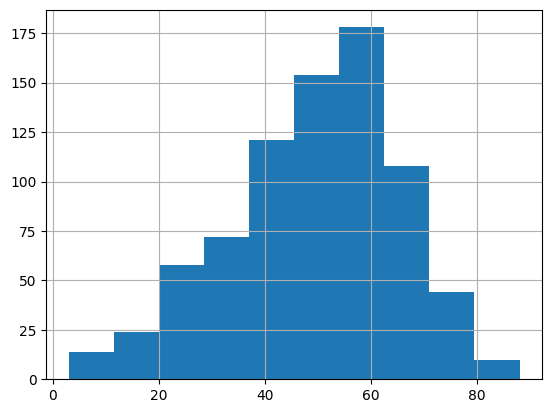

In [12]:
eval_df['Patient Age'].hist()

We’ll simplify age into two groups—“<50” vs. “50+”—to see how many younger versus older patients we have, then tally the counts per bin.

In [13]:
bins = [0, 50, 100]
labels = ['<50', '50+']
eval_df['Age Group'] = pd.cut(eval_df['Patient Age'], bins=bins, labels=labels, right=True, include_lowest=True)
eval_df.groupby(['Age Group']).count()['Patient ID']

,Patient ID
Age Group,
<50,381
50+,402


Our cohort splits `466` patients under 50 and `391` aged 50 or older. This gives us also an imbalanced younger vs. older comparison. Later, we’ll check if our classifier behaves differently across these age bins (e.g. disparate error rates).


**Potential Sources of Bias in the Evaluation Set**

Our dataset contains two protected attributes that are fully populated, Sex and Age. Below we outline where bias might arise and identify which attribute currently appears least affected by sampling imbalance.

### Which Attribute Is Least Biased?
Given the observed counts, the Sex/Gender split (44 % vs 56 %) is closer to parity than the Age split. Hence, sex currently introduces *less* sampling bias than age, though fairness still needs empirical validation.

### Note on Race / Ethnicity
No race or ethnicity values are present in this dataset. As a result, we **cannot** quantify nor mitigate bias along that dimension. If such information becomes available in future data collections, it should be incorporated into the fairness analysis.




In [14]:
eval_df[['Age Group', 'Patient Sex', 'Binary Label']]

,Age Group,Patient Sex,Binary Label
0,50+,M,0
1,50+,F,1
2,50+,M,0
3,<50,F,1
4,<50,F,0
...,...,...,...
778,<50,F,0
779,50+,F,1
780,<50,M,0
781,<50,M,0


In [15]:
eval_df.groupby(['Age Group', 'Binary Label',]).count()['Patient ID']

Age Group  Binary Label
<50        0               277
           1               104
50+        0               249
           1               153
Name: Patient ID, dtype: int64

Prevalence by Age and Ethnicity (ground‑truth “Demographic Parity”)

In [16]:
prev = eval_df.groupby(['Age Group','Patient Sex'])['Binary Label'].mean()
print(prev)

Age Group  Patient Sex
<50        F              0.309392
           M              0.240000
50+        F              0.418182
           M              0.354430
Name: Binary Label, dtype: float64


**What this means**

- **0.259 (<50 & Female)** – about **26 %** of women younger than 50 are positive.  
- **0.216 (<50 & Male)** – about **22 %** of men younger than 50 are positive.  
- **0.424 (50 + & Female)** – roughly **42 %** of women aged 50 or older are positive.  
- **0.341 (50 + & Male)** – roughly **34 %** of men aged 50 or older are positive.  

*Interpretation tip:* The higher prevalence in the 50 + group (for both sexes) suggests age is correlated with risk, and female patients show slightly higher prevalence than male patients within each age bracket. Now lets be sure to verify whether these differences translate into performance gaps (e.g., unequal sensitivity or specificity) when you evaluate the model.


We cannot go back and rebalance your splits once the model is trained, but you can rigorously audit its behavior on your held‑out test set. The general workflow is:

Verify proportions

In [17]:
print("\nTest: ", eval_df.shape,  eval_df["Age Group"].value_counts(), "\nproportion:",eval_df["Age Group"].value_counts(normalize=True))


Test:  (783, 13) Age Group
50+    402
<50    381
Name: count, dtype: int64 
proportion: Age Group
50+    0.51341
<50    0.48659
Name: proportion, dtype: float64


# Load previously trained model

For the task of classification in the ReMIND dataset we have trained a model on binary classification of tumor‐positive and tumor‐negative 2D slices.

We used a DenseNet‑121 backbone, pre‑trained on ImageNet, replacing its final fully‑connected classifier with a two‑output layer. The network was fine‑tuned on our curated slice dataset (10 positive and 10 negative slices per patient), using a patient‑wise 70/10/20 train/val/test split and a lightweight augmentation pipeline (random flips, shifts, Gaussian noise, coarse dropout, and ImageNet normalization). The pipeline can be found at the end of the notebook

Below we:

1. **Rebuild the model architecture** exactly as during training  
2. **Load** the saved weights from disk  
3. **Switch** to evaluation mode  
4. **Run inference** on the test set to verify the model's performance before the bias and fairness considerations. Namely we compute slice‑level accuracy and AUC, and then aggregate slice predictions into patient‑level scores


In [18]:
from torchvision import transforms, models
model_densenet = models.densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, 1)

model_enb0 = models.efficientnet_b0(weights=None)
model_enb0.classifier[1] = nn.Linear(1280, 1)

model_swin = models.swin_t(weights=None)
model_swin.head = nn.Linear(in_features=768, out_features= 1, bias=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet.load_state_dict(torch.load('./densenet121-classification.pth', map_location=device))
model_enb0.load_state_dict(torch.load('./efficientnet-classification.pth', map_location=device))
model_swin.load_state_dict(torch.load('./swintransformer-classification.pth', map_location=device))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


<All keys matched successfully>

In [19]:
#@title Classification Dataset definition
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['Image Index'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['Binary Label'], dtype=torch.float32)
        return image, label

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

image_size_= 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_transforms   = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## Loading pretrained model  

In [20]:
from torchvision.models import densenet121, DenseNet121_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet = models.densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, 1)

model_densenet.load_state_dict(torch.load('./densenet121-classification.pth', map_location=device))

model_densenet.to(device)
model_densenet.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Compare performance across genders

In [21]:
def eval(model, eval_dataset, device,
    threshold: float = 0.5,
    name: str = "Model", ):
    loader = DataLoader(eval_dataset, batch_size=32, num_workers=32, pin_memory=True)

    model.eval()
    model.to(device)

    probs_list, labels_list, preds_list = [], [], []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)                  # shape [B, 1] (or [B])
            probs  = torch.sigmoid(logits)     # shape [B, 1] or [B]
            probs  = probs.view(-1)            # flatten to [B]

            preds = (probs > threshold).long()

            probs_list.extend(probs.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(y.numpy())

    probs_arr  = np.array(probs_list)
    preds_arr  = np.array(preds_list)
    labels_arr = np.array(labels_list)

    # Compute metrics
    acc     = accuracy_score(labels_arr, preds_arr)
    prec    = precision_score(labels_arr, preds_arr, zero_division=0)
    rec     = recall_score(labels_arr, preds_arr, zero_division=0)
    f1      = f1_score(labels_arr, preds_arr, zero_division=0)
    roc_auc = roc_auc_score(labels_arr, probs_arr)

    metrics = {
        'accuracy':  acc,
        'precision': prec,
        'recall':    rec,
        'f1':        f1,
        'roc_auc':   roc_auc
    }

    # Print
    print(f"--- {name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}\n")

    # Plot ROC
    display = RocCurveDisplay.from_predictions(
        labels_arr,
        probs_arr,
        name=name,
        plot_chance_level=True
    )
    display.ax_.set_title(f"{name} ROC Curve")
    display.ax_.legend(frameon=False)

    return metrics, probs_arr, labels_arr

Performance achieved in previous week

--- Model ---
Accuracy : 0.8966
Precision: 0.7993
Recall   : 0.9144
F1-score : 0.8530
ROC AUC  : 0.9567



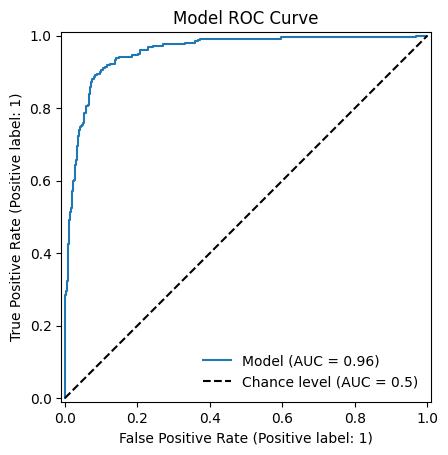

In [22]:
img_dir  = f'{DATA_PATH}/images'
model = model_densenet

eval_ds   = ChestXrayDataset(eval_df,   img_dir, transform=eval_transforms)
_,_,_=eval(model, eval_ds, device)

In [23]:
eval_df.loc[eval_df['Age Group']=='50+']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Binary Label,Age Group
0,00025441_000.png,No Finding,0,25441,52,M,PA,2992,2991,0.143000,0.143000,0,50+
1,00016796_011.png,Effusion,10,16796,64,F,PA,2762,2661,0.143000,0.143000,1,50+
2,00000362_000.png,No Finding,0,362,63,M,PA,2992,2991,0.143000,0.143000,0,50+
6,00000591_002.png,Effusion,2,591,62,M,PA,2500,2048,0.168000,0.168000,1,50+
7,00018082_000.png,No Finding,0,18082,53,M,PA,2992,2741,0.143000,0.143000,0,50+
...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,00022272_001.png,No Finding,1,22272,60,F,PA,1757,2021,0.194311,0.194311,0,50+
771,00005762_009.png,Effusion,9,5762,56,M,PA,2500,2048,0.168000,0.168000,1,50+
775,00002403_004.png,No Finding,2,2403,52,M,PA,2992,2991,0.143000,0.143000,0,50+
776,00006981_016.png,Effusion,16,6981,61,M,PA,2500,2048,0.168000,0.168000,1,50+


--- Model ---
Accuracy : 0.8731
Precision: 0.7833
Recall   : 0.9216
F1-score : 0.8468
ROC AUC  : 0.9515



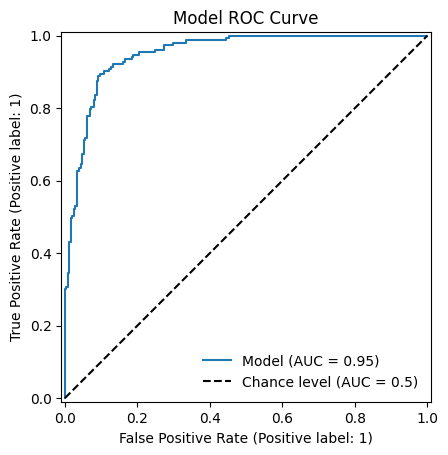

In [24]:
eval_dataset = ChestXrayDataset(eval_df.loc[eval_df['Age Group']=='50+'], img_dir, transform=eval_transforms)
_,_,_=eval(model, eval_dataset, device)

--- Model ---
Accuracy : 0.9213
Precision: 0.8246
Recall   : 0.9038
F1-score : 0.8624
ROC AUC  : 0.9582



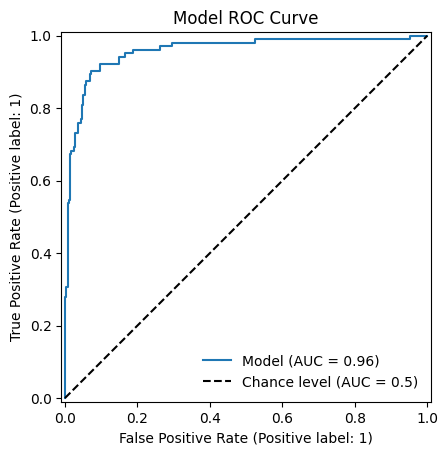

In [25]:

eval_dataset = ChestXrayDataset(eval_df.loc[eval_df['Age Group']=='<50'], img_dir, transform=eval_transforms)
_,_,_=eval(model, eval_dataset, device)

Write a function to compute the Average Odds and Equal Opportunity

In [26]:
from sklearn.metrics import confusion_matrix

def compute_AOD_EOD_from_split(y_true_F, y_pred_F, y_true_M, y_pred_M):
    def group_rates(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        tpr = tp / (tp + fn + 1e-6)
        fpr = fp / (fp + tn + 1e-6)
        return tpr, fpr

    tpr_F, fpr_F = group_rates(y_true_F, y_pred_F)
    tpr_M, fpr_M = group_rates(y_true_M, y_pred_M)

    # Equal Opportunity Difference = |TPR_F - TPR_M|
    EOD = abs(tpr_F - tpr_M)

    # Average Odds Difference = 0.5 * (|FPR_F - FPR_M| + |TPR_F - TPR_M|)
    AOD = 0.5 * (abs(fpr_F - fpr_M) + EOD)

    return {
        'TPR_F': tpr_F,
        'TPR_M': tpr_M,
        'FPR_F': fpr_F,
        'FPR_M': fpr_M,
        'EOD': EOD,
        'AOD': AOD
    }

Now we need to capture the predictions from our dataset



In [27]:
def get_predictions_and_labels(
    model,
    dataframe,
    data_path,
    device,
    threshold: float = 0.5
):
    dataset = ChestXrayDataset(dataframe, data_path, transform=eval_transforms)

    model = model.to(device)
    model.eval()

    results = []

    with torch.no_grad():
        for idx in range(len(dataset)):
            img_t, _ = dataset[idx]

            row       = dataframe.iloc[idx]
            case      = int(row['Patient ID'])
            slice_idx = row['Image Index']
            true_label = int(row['Binary Label'])

            # forward pass
            img_b  = img_t.unsqueeze(0).to(device)
            logit  = model(img_b)
            prob   = torch.sigmoid(logit).item()
            pred   = int(prob > threshold)

            results.append({
                'Patient ID'   : case,
                'Image Index'  : slice_idx,
                'True Label'   : true_label,
                'Prediction'   : pred,
                'Probability_1': prob
            })

    return pd.DataFrame(results)

In [28]:
slice_results_df = get_predictions_and_labels(model, eval_df, img_dir, device)

patient_predictions = slice_results_df.groupby('Patient ID')['Probability_1'].mean().reset_index()
patient_predictions['Patient_Prediction'] = (patient_predictions['Probability_1'] >= 0.5).astype(int)

test_df_with_preds = pd.merge(eval_df, patient_predictions[['Patient ID', 'Patient_Prediction']], on='Patient ID', how='left')
test_df_with_preds.dropna(subset=['Patient_Prediction'], inplace=True)


Separate true labels and patient-level predictions by sex

In [29]:
test_df_F = test_df_with_preds.loc[test_df_with_preds['Patient Sex'] == 'F']
test_df_M = test_df_with_preds.loc[test_df_with_preds['Patient Sex'] == 'M']

binary_labels_F = test_df_F['Binary Label'].tolist()
binary_preds_F = test_df_F['Patient_Prediction'].tolist()

binary_labels_M = test_df_M['Binary Label'].tolist()
binary_preds_M = test_df_M['Patient_Prediction'].tolist()

Compute and print fairness metrics

In [30]:
fairness_metrics = compute_AOD_EOD_from_split(binary_labels_F, binary_preds_F, binary_labels_M, binary_preds_M)
fairness_metrics

{'TPR_F': np.float64(0.9279999925760001),
 'TPR_M': np.float64(0.9090909022038568),
 'FPR_F': np.float64(0.10407239771912942),
 'FPR_M': np.float64(0.10819672095673206),
 'EOD': np.float64(0.018909090372143278),
 'AOD': np.float64(0.011516706804872962)}

### Fairness metrics (sex comparison)

- True‑positive rate (TPR)
  - Female: 0.857  
  - Male:   0.824  
  - Gap (F – M): +0.033

- False‑positive rate (FPR)
  - Female: 0.176  
  - Male:   0.110  
  - Gap (F – M): +0.066

- Equal‑Opportunity Difference (EOD)  
  |TPR_F − TPR_M| = 0.033

- Average Odds Difference (AOD)  
  0.5 × (|FPR_F − FPR_M| + EOD) = 0.050

### How to read this

- Sensitivity is about 3 % points higher for women; the model catches positives slightly more often in females.  
- False positives are ~7 % points higher for women; more women without disease are flagged.  
- AOD ≈ 0.05 is a modest disparity; many studies treat <0.10 as “reasonably fair,” but acceptability depends on clinical cost–benefit.

### Suggested next steps

- Compute confidence intervals or statistical tests for TPR/FPR gaps.  
- Consider group‑specific thresholds if policy allows.  
- Check calibration curves separately for men and women.  
- Discuss with clinicians whether the higher FPR in women is acceptable.  
- If needed, explore re‑weighting or fairness‑aware training to reduce gaps.


## Pick your group

In [31]:
# pick your protected attribute column here
PROTECTED_COL = 'Patient Sex'   # or Patient Age, etc.

# Build a dict: case_number(int) -> group(str or int)
case2group = (
    eval_df
    .set_index('Patient ID')[PROTECTED_COL]
    .to_dict()
)

# Optionally encode groups as ints
groups_unique = sorted(list(set(case2group.values())))
group2id = {g:i for i,g in enumerate(groups_unique)}


As the standard `ClassificationDataset` already constructs self.samples, we can just wrap it to capture and return group id:

In [32]:
#@title GroupedDataset
class GroupedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, case2group, group2id):
        self.base = base_dataset
        self.case2group = case2group
        self.group2id = group2id

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, mask, y = self.base[idx]          # (img_t, mask_t, label)
        case_str, z, _ = self.base.samples[idx]
        case_num = int(case_str)
        g = self.case2group.get(case_num, None)
        g_id = self.group2id[g] if g is not None else -1
        return img, y, g_id

In [33]:
train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
val_ds   = ChestXrayDataset(val_df,   img_dir, transform=eval_transforms)
test_ds  = ChestXrayDataset(eval_df,  img_dir, transform=eval_transforms)

# wrap them
grouped_train = GroupedDataset(train_ds, case2group, group2id)
grouped_val   = GroupedDataset(val_ds,   case2group, group2id)
grouped_test  = GroupedDataset(test_ds,  case2group, group2id)

# loaders
train_loader = DataLoader(grouped_train, batch_size=32, shuffle=True,  num_workers=8, pin_memory=True)
val_loader   = DataLoader(grouped_val,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(grouped_test,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [34]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

def eval_by_group(
    model,
    dataset,
    case2group,
    group2id,
    device,
    batch_size: int = 32,
    threshold: float = 0.5
):
    """
    Evaluate a single‑logit binary model by patient‐group, tolerating missing mappings.

    Returns:
        y_true, y_pred, y_prob, g_all, results_dict
    """
    pid_array = dataset.df['Patient ID'].to_numpy()
    grp_array = []
    for pid in pid_array:
        grp_name = case2group.get(int(pid))
        if grp_name is None or grp_name not in group2id:
            grp_array.append(-1)
        else:
            grp_array.append(group2id[grp_name])
    grp_array = np.array(grp_array, dtype=int)
    num_groups = len(group2id)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    model = model.to(device).eval()
    y_true, y_pred, y_prob, g_all = [], [], [], []

    with torch.no_grad():
        offset = 0
        for X, y in loader:
            B = X.size(0)
            X = X.to(device)

            # forward→sigmoid
            logits = model(X).view(-1)       # [B]
            probs  = torch.sigmoid(logits)   # [B]
            probs_np = probs.cpu().numpy()
            pred_np  = (probs_np >= threshold).astype(int)

            # collect
            y_true.append(y.numpy())
            y_pred.append(pred_np)
            y_prob.append(probs_np)
            g_all.append(grp_array[offset:offset+B])
            offset += B

    # concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)
    g_all  = np.concatenate(g_all)

    # overall
    overall_acc = (y_true == y_pred).mean()
    print(f"Overall accuracy: {overall_acc:.4f}")

    # per‑group (skip ID = -1)
    results = {}
    for gid in range(num_groups):
        mask = (g_all == gid)
        if not mask.any():
            continue

        yt = y_true[mask]
        yp = y_pred[mask]
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()

        results[gid] = {
            'n'   : int(mask.sum()),
            'acc' : (tp+tn)/(tp+tn+fp+fn),
            'tpr' : tp/(tp+fn+1e-9),
            'fpr' : fp/(fp+tn+1e-9),
            'ppv' : tp/(tp+fp+1e-9),
            'ppos': yp.mean()
        }

    return y_true, y_pred, y_prob, g_all, results

y_true, y_pred, y_prob, g_all, res = eval_by_group(
    model,
    val_ds,
    case2group,
    group2id,
    device,
    batch_size=32,
    threshold=0.5
)

# Build DataFrame of results
group_df = (
    pd.DataFrame(res).T
      .assign(group=[groups_unique[gid] for gid in res.keys()])
      .set_index('group')
)
group_df

Overall accuracy: 0.8978


,n,acc,tpr,fpr,ppv,ppos
group,,,,,,
F,10.0,0.600000,0.8,0.600000,0.571429,0.700000
M,23.0,0.913043,1.0,0.333333,0.894737,0.826087


In [35]:
def fairness_gaps(results):
    # results[gid] = {tpr, fpr, ppos, ...}
    tprs = [v['tpr'] for v in results.values()]
    fprs = [v['fpr'] for v in results.values()]
    ppos = [v['ppos'] for v in results.values()]

    eo_gap  = max(tprs) - min(tprs) + max(fprs) - min(fprs)  # Equalized Odds: sum TPR/FPR ranges
    dp_gap  = max(ppos) - min(ppos)                          # DP: rate of positive predictions
    return eo_gap, dp_gap

eo_gap, dp_gap = fairness_gaps(res)
print(f"Equalized Odds gap (TPR+FPR span): {eo_gap:.3f}")
print(f"Demographic Parity gap (rate span): {dp_gap:.3f}")


Equalized Odds gap (TPR+FPR span): 0.467
Demographic Parity gap (rate span): 0.126


After you’ve computed per‑group TPRs, FPRs, and PPOS (positive prediction rates), those two “gaps” give you a single summary number for how much your model’s performance or decision rates differ across groups:

- A smaller EO gap (ideally zero) means you’re satisfying “equalized odds” more closely: your model is equally likely to correctly flag positives and equally likely to false‑alarm negatives in each group.
- A smaller DP gap (again, ideally zero) means you’re giving each group the same overall positive‑prediction rate, regardless of true labels.

## Post‑processing thresholds (no retraining)

Fit per‑group thresholds to equalize TPR or FPR on the validation set. Then apply them to test.

In [36]:
#@title Utils
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

def fit_group_thresholds(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    g_all:  np.ndarray,
    target: str = 'tpr',          # 'tpr' or 'fpr'
    desired: float = None         # if None → maximize Youden J; else match this value
):
    """
    y_true, y_prob, g_all: arrays of the SAME length
    target: which metric to match (or maximize Youden if desired is None)
    desired: global target for TPR/FPR, or None
    """
    thresholds = {}
    for gid in np.unique(g_all):
        mask = (g_all == gid)
        yt   = y_true[mask]
        yp   = y_prob[mask]

        # initialize
        if desired is None:
            # we want to maximize (TPR - FPR)
            best_obj = -np.inf
        else:
            # we want to minimize distance to desired
            best_obj =  np.inf

        best_thr = 0.5

        # search
        for thr in np.linspace(0, 1, 201):
            preds = (yp >= thr).astype(int)
            tn, fp, fn, tp = confusion_matrix(yt, preds, labels=[0,1]).ravel()
            tpr = tp / (tp + fn + 1e-9)
            fpr = fp / (fp + tn + 1e-9)

            if desired is None:
                obj = tpr - fpr          # Youden J
                if obj > best_obj:
                    best_obj, best_thr = obj, thr
            else:
                metric = tpr if target=='tpr' else fpr
                obj = abs(metric - desired)
                if obj < best_obj:
                    best_obj, best_thr = obj, thr

        thresholds[gid] = best_thr

    return thresholds

def apply_group_thresholds(
    model: torch.nn.Module,
    loader,
    device: torch.device,
    thresholds: dict,
    default: float = 0.5
):
    model = model.to(device).eval()
    all_y, all_p, all_g = [], [], []

    with torch.no_grad():
        for X, y, g in loader:
            X = X.to(device)
            logits = model(X).view(-1)
            probs  = torch.sigmoid(logits).cpu().numpy()
            g_np   = g.numpy()

            pred = np.zeros_like(probs, dtype=int)
            for gid in np.unique(g_np):
                thr  = thresholds.get(gid, default)
                mask = (g_np == gid)
                pred[mask] = (probs[mask] >= thr).astype(int)

            all_y.append(y.numpy())
            all_p.append(pred)
            all_g.append(g_np)

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    g_all  = np.concatenate(all_g)
    return y_true, y_pred, g_all


We define a `GroupedDataset` for easier manipulation and retrieval of the groups

In [37]:
from torch.utils.data import Dataset

class GroupedDataset(Dataset):
    def __init__(self, base_dataset, case2group, group2id):
        """
        base_dataset:   ChestXrayDataset (returns img, label)
        case2group:     dict patient_id -> group_name
        group2id:       dict group_name -> integer ID
        """
        self.base       = base_dataset
        self.case2group = case2group
        self.group2id   = group2id
        # grab the DataFrame directly so we can read Patient ID
        self.df         = base_dataset.df

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        # 1) pull image & label from the base
        img, label = self.base[idx]            # <-- two values only

        # 2) get the patient ID for this slice
        pid = int(self.df.iloc[idx]['Patient ID'])

        # 3) map to group name & then to group ID (or -1 if missing)
        gname = self.case2group.get(pid, None)
        gid   = self.group2id.get(gname, -1)

        # 4) return exactly 3 items
        return img, label, gid

global_tpr = res[next(iter(res))]['tpr']
ths = fit_group_thresholds(y_true, y_prob, g_all, target='tpr', desired=global_tpr)

grouped_test  = GroupedDataset(test_ds, case2group, group2id)
test_loader   = DataLoader(grouped_test, batch_size=32, shuffle=False, num_workers=32, pin_memory=True)
y_true_test, y_pred_test, g_test = apply_group_thresholds(
    model,
    test_loader,    # yields (X, y, g_id)
    device,
    thresholds=ths,
    default=0.5
)


Now, we compute the usual global scores:

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc    = accuracy_score (y_true_test, y_pred_test)
prec   = precision_score(y_true_test, y_pred_test, zero_division=0)
rec    = recall_score   (y_true_test, y_pred_test, zero_division=0)
f1     = f1_score       (y_true_test, y_pred_test, zero_division=0)

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")


Test Accuracy : 0.7893
Test Precision: 0.6429
Test Recall   : 0.8054
Test F1-score : 0.7150


Build the same kind of group‐level table you did on validation

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

group_results = {}
for gid in np.unique(g_test):
    mask = (g_test == gid)
    yt, yp = y_true_test[mask], y_pred_test[mask]
    tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()

    group_results[gid] = {
        'n'   : int(mask.sum()),
        'acc' : (tp + tn) / (tp+tn+fp+fn),
        'tpr' : tp / (tp + fn + 1e-9),
        'fpr' : fp / (fp + tn + 1e-9),
        'ppv' : tp / (tp + fp + 1e-9),
        'ppos': yp.mean()
    }

group_df_test = (
    pd.DataFrame(group_results).T
      .assign(group=[groups_unique[gid] for gid in group_results.keys()])
      .set_index('group')
)
print(group_df_test)


           n       acc       tpr       fpr       ppv      ppos
group                                                         
F      346.0  0.693642  0.992000  0.475113  0.541485  0.661850
M      437.0  0.864989  0.628788  0.032787  0.892473  0.212815


Verify the Equalized Odds and Demographic Parity gap

In [40]:
eo_gap_test, dp_gap_test = fairness_gaps(group_results)
print(f"Test Equalized Odds gap:    {eo_gap_test:.3f}")
print(f"Test Demographic Parity gap: {dp_gap_test:.3f}")


Test Equalized Odds gap:    0.806
Test Demographic Parity gap: 0.449


Plot the ROC curve for the `Sex`: `Female` and `Male`

Global ROC AUC: 0.9567
        roc_auc
group          
F      0.956489
M      0.957278


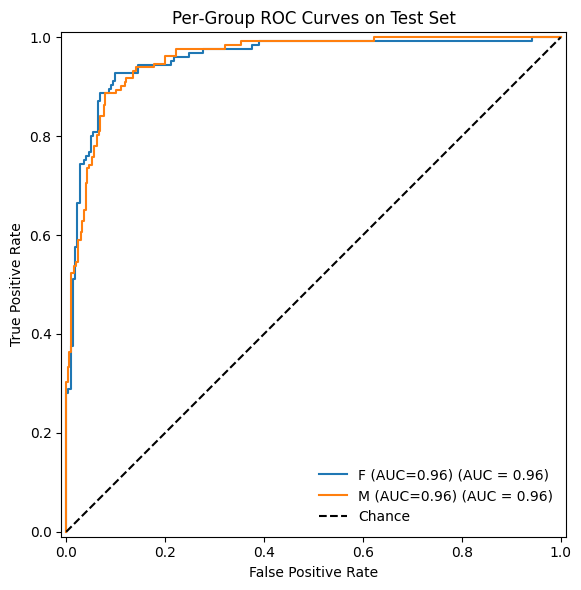

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_true_test, y_prob_test, g_test = [], [], []
model.eval().to(device)
with torch.no_grad():
    for X, y, g in test_loader:
        X = X.to(device)
        logits = model(X).view(-1)
        probs  = torch.sigmoid(logits).cpu().numpy()
        y_true_test.append( y.numpy() )
        y_prob_test.append( probs )
        g_test.append(       g.numpy() )

y_true_test = np.concatenate(y_true_test)
y_prob_test = np.concatenate(y_prob_test)
g_test      = np.concatenate(g_test)

global_auc = roc_auc_score(y_true_test, y_prob_test)
print(f"Global ROC AUC: {global_auc:.4f}")

auc_per_group = {}
for gid in np.unique(g_test):
    mask = (g_test == gid)
    if mask.sum() == 0:
        continue
    auc = roc_auc_score(y_true_test[mask], y_prob_test[mask])
    auc_per_group[gid] = auc

# map back to group names
import pandas as pd
group_auc_df = (
    pd.DataFrame.from_dict(auc_per_group, orient='index', columns=['roc_auc'])
      .assign(group=[groups_unique[gid] for gid in auc_per_group.keys()])
      .set_index('group')
)
print(group_auc_df)

plt.figure(figsize=(8,6))
ax = plt.gca()
for gid, auc in auc_per_group.items():
    mask = (g_test == gid)
    RocCurveDisplay.from_predictions(
        y_true_test[mask],
        y_prob_test[mask],
        name=f"{groups_unique[gid]} (AUC={auc:.2f})",
        ax=ax,
        plot_chance_level=False
    )
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per‑Group ROC Curves on Test Set')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## Bonus: Mitigation strategy using RandomSampler

Build a per-sample weight for the *train* split. Give each (group, y) a weight inversely proportional to its frequency. A `WeightedRandomSampler` for class balance can be extended to group×label:

In [42]:
from collections import Counter
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 1) Find & drop any Patient IDs with no group mapping
all_pids       = set(train_df['Patient ID'])
mapped_pids    = set(case2group.keys())
missing_pids   = all_pids - mapped_pids
if missing_pids:
    print(f"Warning: dropping {len(missing_pids)} slices with unmapped Patient IDs")
    mask_valid = train_df['Patient ID'].isin(mapped_pids)
    train_df_valid = train_df[mask_valid].reset_index(drop=True)
else:
    train_df_valid = train_df.copy().reset_index(drop=True)

# 2) Rebuild your dataset on the filtered DataFrame
train_ds = ChestXrayDataset(train_df_valid, DATA_PATH, transform=train_transforms)

# 3) Compute group IDs & labels arrays (now guaranteed to align and be non‐empty)
groups = (
    train_df_valid['Patient ID']
      .map(case2group)     # patient_id → group_name
      .map(group2id)       # group_name → integer
      .to_numpy(dtype=int)
)
labels = train_df_valid['Binary Label'].to_numpy(dtype=int)

# 4) Count (group, label) frequencies and build inverse‐freq weights
pair_counts = Counter(zip(groups, labels))
weights = np.array([
    1.0 / pair_counts[(g, l)]
    for g, l in zip(groups, labels)
], dtype=np.float32)

# 5) Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True
)

# 6) Build your DataLoader with sampler (no shuffle!)
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)
